### Dicas
#### Relação entre Pandas e SQL

| SQL                 | pandas                                         |
| ------------------- | ---------------------------------------------- |
| `SELECT col1, col2` | `df[["col1", "col2"]]`                         |
| `WHERE condição`    | `df[df["col"] > 10]`                           |
| `GROUP BY col`      | `df.groupby("col")`                            |
| `ORDER BY col`      | `df.sort_values(by="col")`                     |
| `SUM(col)`          | `df["col"].sum()` ou `df.groupby(...).sum()`   |
| `AVG(col)`          | `df["col"].mean()` ou `df.groupby(...).mean()` |
| `COUNT(*)`          | `df.shape[0]` ou `df.groupby(...).size()`      |
| `JOIN`              | `pd.merge(df1, df2, on="chave")`               |
| `DISTINCT`          | `df["col"].unique()` ou `df.drop_duplicates()` |

# Estatísticas

In [2]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

RESULTS_DIR = Path("resultados")

NOMES_OCR = {
    "TESSERACT": "Tesseract",
    "TESSERACT_THREAD": "Tesseract Thread",
    "EASYOCR": "EasyOCR",
    "EASYOCR_THREAD": "EasyOCR Batch",
}

NOMES_GRADE = {
    "CANNY": "Canny Edge Detection",
    "COR": "Segmentação por Cor",
    "CANNY_FIXED": "Canny Edge Detection (1º detecção)",
    "COR_FIXED": "Segmentação por Cor (1º detecção)",
}

NOMES_DIFICULDADE = {"EASY": "Fácil", "MEDIUM": "Médio", "HARD": "Difícil"}
ORDEM_DIFICULDADE = ["Fácil", "Médio", "Difícil"]

NOMES_CARDS = {"COR": "Segmentação por Cor", "TEMPLATE": "Template Matching"}

NOMES_PARES = {"SSIM": "SSIM", "TEMPLATE_MATCHING": "Template Matching"}

TOTAL_CARTAS = {"EASY": 12, "MEDIUM": 24, "HARD": 48}

TOTAL_PARES = {k: v // 2 for k, v in TOTAL_CARTAS.items()}

NOME_METRICA = {"precisao": "Precisão", "recall": "Recall", "f1": "F1-score"}


def ajustar_unidade_tempo(serie: pd.Series) -> tuple[pd.Series, str]:
    """Ajusta a unidade do tempo, para ser usado nos dataframes de tempo

    Args:
        serie (pd.Series): Série com os tempos em nanosegundos

    Returns:
        tuple[pd.Series, str]: Série com os tempos convertidos e a unidade
    """
    media = serie.mean()

    if media > 1_000_000_000:
        return serie / 1_000_000_000, "s"
    elif media > 1_000_000:
        return serie / 1_000_000, "ms"
    elif media > 1_000:
        return serie / 1_000, "µs"
    else:
        return serie, "ns"

## Utils

In [8]:
JSON_NAME = "resultados_think_2048.json"
with open(RESULTS_DIR / JSON_NAME, "r", encoding="utf-8") as f:
    raw_resultados = json.load(f)

# Lista onde vamos armazenar os dados "explodidos"
dados_linhas = []

# Expande as listas em linhas individuais
for r in raw_resultados:
    ocr = r["ocr"]
    grade = r["grade"]
    falhas = r.get("falhas_grid", 0)

    maiores_numeros = r.get("maiores_numeros", [])
    pontuacoes = r.get("pontuacoes", [])
    tempos = r.get("tempos", [])

    n = min(len(maiores_numeros), len(pontuacoes), len(tempos))

    for i in range(n):
        dados_linhas.append({
            "ocr": ocr,
            "grade": grade,
            "falhas_grid": falhas,
            "maior_numero": maiores_numeros[i],
            "pontuacao": pontuacoes[i],
            "tempo": tempos[i]
        })

# Cria o DataFrame
df = pd.DataFrame(dados_linhas)

# Salva como Parquet (compactado com snappy)
df.to_parquet(RESULTS_DIR / JSON_NAME.replace("json", "parquet"), index=False)

## 2048

Métrica 1: Tempo médio por combinação

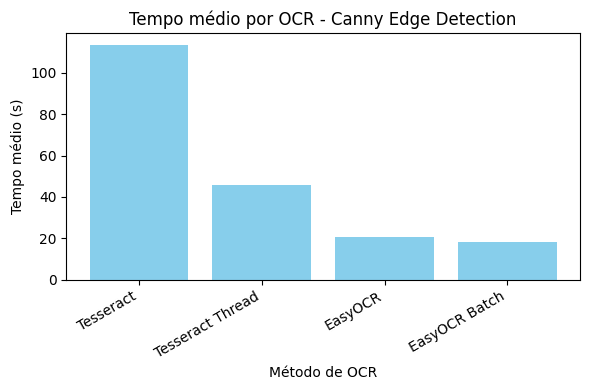

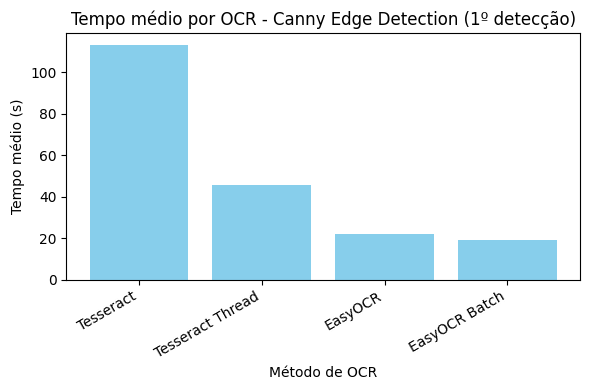

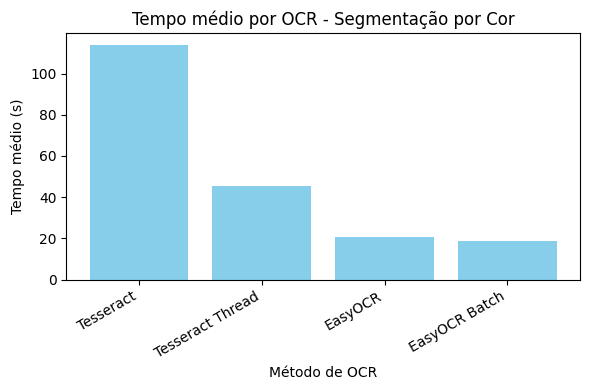

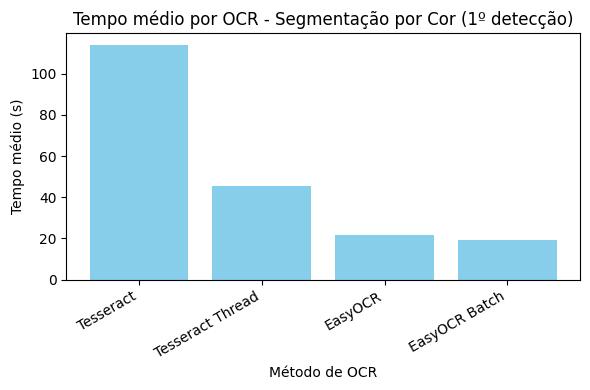

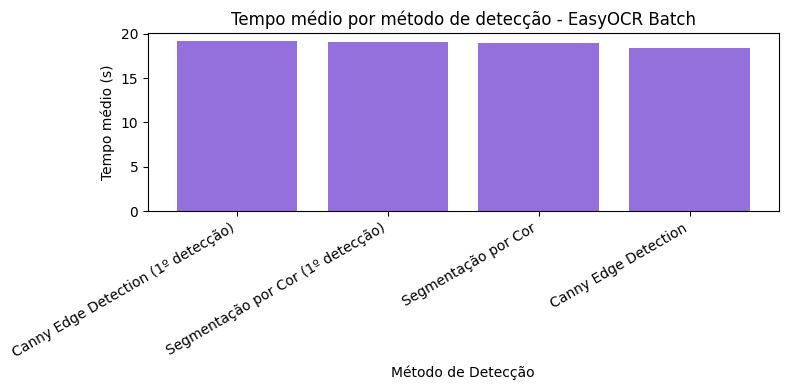

,Método,Mínimo,Máximo,Média,Desvio_Padrão
11,Tesseract + Segmentação por Cor (1º detecção),113.88,114.63,114.13,0.21
10,Tesseract + Segmentação por Cor,113.72,114.60,114.07,0.24
8,Tesseract + Canny Edge Detection,112.75,114.35,113.63,0.50
9,Tesseract + Canny Edge Detection (1º detecção),112.95,113.78,113.22,0.22
12,Tesseract Thread + Canny Edge Detection,45.55,46.57,45.91,0.25
13,Tesseract Thread + Canny Edge Detection (1º detecção),45.29,46.97,45.72,0.49
14,Tesseract Thread + Segmentação por Cor,45.02,45.99,45.53,0.23
15,Tesseract Thread + Segmentação por Cor (1º detecção),45.03,46.42,45.45,0.31
3,EasyOCR + Segmentação por Cor (1º detecção),21.59,22.11,21.87,0.17
1,EasyOCR + Canny Edge Detection (1º detecção),21.17,22.16,21.75,0.25


In [2]:
# Carrega os resultados
df = pd.read_parquet(RESULTS_DIR / "resultados_2048.parquet")


# Aplica os nomes legíveis (OCR e grade)
df["OCR_legivel"] = df["ocr"].map(NOMES_OCR).fillna(df["ocr"])
df["Grade_legivel"] = df["grade"].map(NOMES_GRADE).fillna(df["grade"])

# --- Gráfico: tempo médio por OCR, separado por método de grade ---
for grade_legivel, grupo in df.groupby("Grade_legivel"):
    medias = grupo.groupby("OCR_legivel")["tempo"].mean().sort_values(ascending=False)

    plt.figure(figsize=(6, 4))
    plt.bar(medias.index, medias.values, color="skyblue")
    plt.title(f"Tempo médio por OCR - {grade_legivel}")
    plt.ylabel("Tempo médio (s)")
    plt.xlabel("Método de OCR")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

# --- Gráfico: tempo médio por grade com OCR fixo ---
ocr_fixo_legivel = "EasyOCR Batch"
df_ocr_fixo = df[df["OCR_legivel"] == ocr_fixo_legivel]

medias_grade = df_ocr_fixo.groupby("Grade_legivel")["tempo"].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
plt.bar(medias_grade.index, medias_grade.values, color="mediumpurple")
plt.title(f"Tempo médio por método de detecção - {ocr_fixo_legivel}")
plt.ylabel("Tempo médio (s)")
plt.xlabel("Método de Detecção")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# --- Tabela de estatísticas descritivas por combinação OCR + Grade ---
estatisticas = df.groupby(["OCR_legivel", "Grade_legivel"])["tempo"].agg(
    Mínimo="min",
    Máximo="max",
    Média="mean",
    Desvio_Padrão="std"
).reset_index()

# Junta as colunas em um label de método
estatisticas["Método"] = estatisticas["OCR_legivel"] + " + " + estatisticas["Grade_legivel"]

# Reorganiza colunas
estatisticas = estatisticas[["Método", "Mínimo", "Máximo", "Média", "Desvio_Padrão"]]
estatisticas = estatisticas.sort_values(by="Média", ascending=False)

# --- Exibe a tabela formatada ---
estatisticas.style.format({
    "Mínimo": "{:.2f}",
    "Máximo": "{:.2f}",
    "Média": "{:.2f}",
    "Desvio_Padrão": "{:.2f}"
})

Métrica 2: Pontuação e Máx tile por partida (de um método específico = EasyOCR Batch + Cor Fixed) 

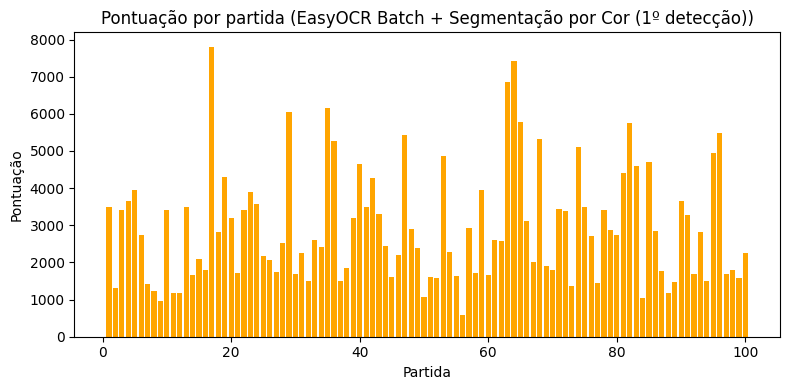

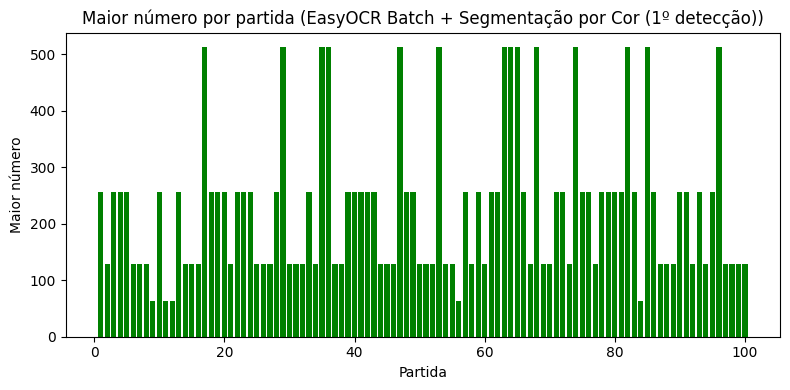

,Métrica,Mínimo,Máximo,Média,Desvio Padrão
0,Pontuação,588.00,7804.00,2952.64,1542.75
1,Maior número,64.00,512.00,229.76,131.22


In [4]:
# Carrega os resultados
df = pd.read_parquet(RESULTS_DIR / "resultados_think_2048.parquet")

ocr = df["ocr"].iloc[0]
grade = df["grade"].iloc[0]
nome_ocr = NOMES_OCR.get(ocr, ocr)
nome_grade = NOMES_GRADE.get(grade, grade)

# --- Gráfico: Pontuações por partida ---
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(df) + 1), df["pontuacao"], color="orange")
plt.title(f"Pontuação por partida ({nome_ocr} + {nome_grade})")
plt.xlabel("Partida")
plt.ylabel("Pontuação")
plt.tight_layout()
plt.show()

# --- Gráfico: Maior número por partida ---
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(df) + 1), df["maior_numero"], color="green")
plt.title(f"Maior número por partida ({nome_ocr} + {nome_grade})")
plt.xlabel("Partida")
plt.ylabel("Maior número")
plt.tight_layout()
plt.show()

# --- Tabela com estatísticas ---
tabela_stats = pd.DataFrame(
    {
        "Métrica": ["Pontuação", "Maior número"],
        "Mínimo": [df["pontuacao"].min(), df["maior_numero"].min()],
        "Máximo": [df["pontuacao"].max(), df["maior_numero"].max()],
        "Média": [df["pontuacao"].mean(), df["maior_numero"].mean()],
        "Desvio Padrão": [df["pontuacao"].std(), df["maior_numero"].std()],
    }
)

# --- Exibe a tabela formatada ---
tabela_stats.style.format({
    "Mínimo": "{:.2f}",
    "Máximo": "{:.2f}",
    "Média": "{:.2f}",
    "Desvio Padrão": "{:.2f}"
})

## DistroCards

Métrica 1: Tempo médio do Sense por combinação de (método x dificuldade)

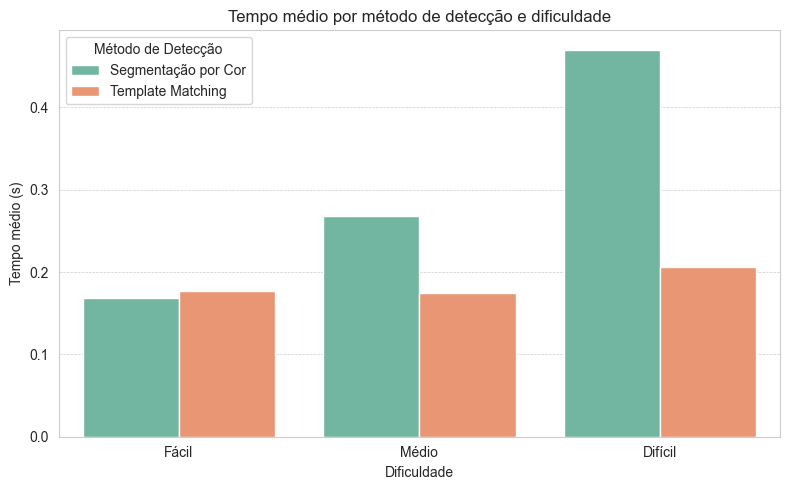

\begin{tabular}{llrrrr}
\toprule
Método & Dificuldade & Mínimo & Máximo & Média & Desvio Padrão \\
\midrule
Segmentação por Cor & Fácil & 0.149 & 0.195 & 0.168 & 0.011 \\
Segmentação por Cor & Médio & 0.247 & 0.297 & 0.268 & 0.011 \\
Segmentação por Cor & Difícil & 0.440 & 0.526 & 0.470 & 0.014 \\
Template Matching & Fácil & 0.159 & 0.210 & 0.177 & 0.010 \\
Template Matching & Médio & 0.157 & 0.204 & 0.174 & 0.011 \\
Template Matching & Difícil & 0.191 & 0.233 & 0.207 & 0.010 \\
\bottomrule
\end{tabular}



,Método,Dificuldade,Mínimo,Máximo,Média,Desvio Padrão
0,Segmentação por Cor,Fácil,0.149,0.195,0.168,0.011
1,Segmentação por Cor,Médio,0.247,0.297,0.268,0.011
2,Segmentação por Cor,Difícil,0.440,0.526,0.470,0.014
3,Template Matching,Fácil,0.159,0.210,0.177,0.010
4,Template Matching,Médio,0.157,0.204,0.174,0.011
5,Template Matching,Difícil,0.191,0.233,0.207,0.010


In [ ]:
# Carrega os resultados
df = pd.read_parquet(RESULTS_DIR / "resultados_sense_distrocards.parquet")

# Aplica os nomes legíveis
df["dificuldade_legivel"] = df["dificuldade"].map(NOMES_DIFICULDADE)
df["metodo_legivel"] = df["metodo"].map(NOMES_CARDS)

# Agrupa com média de tempo por método e dificuldade
df_media = (
    df.groupby(["dificuldade_legivel", "metodo_legivel"], observed=False)["tempo"]
    .mean()
    .reset_index()
)

# Garante a ordem correta das dificuldades
ORDEM_DIFICULDADE = ["Fácil", "Médio", "Difícil"]
df_media["dificuldade_legivel"] = pd.Categorical(
    df_media["dificuldade_legivel"], categories=ORDEM_DIFICULDADE, ordered=True
)

# Cria o gráfico
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")

ax = sns.barplot(
    data=df_media,
    x="dificuldade_legivel",
    y="tempo",
    hue="metodo_legivel",
    palette="Set2"
)

plt.title("Tempo médio por método de detecção e dificuldade")
plt.xlabel("Dificuldade")
plt.ylabel("Tempo médio (s)")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.legend(title="Método de Detecção")
plt.tight_layout()
plt.show()

# --- Tabela de estatísticas ---
df["dificuldade_legivel"] = pd.Categorical(df["dificuldade_legivel"], categories=ORDEM_DIFICULDADE, ordered=True)
tabela_stats = (
    df
    .groupby(["metodo_legivel", "dificuldade_legivel"], observed=False)["tempo"]
    .agg(["min", "max", "mean", "std"])
    .reset_index()
    .rename(columns={
        "metodo_legivel": "Método",
        "dificuldade_legivel": "Dificuldade",
        "min": "Mínimo",
        "max": "Máximo",
        "mean": "Média",
        "std": "Desvio Padrão"
    })
    .sort_values(by=["Método", "Dificuldade"])
)

print(tabela_stats.to_latex(index=False, float_format="%.3f"))

# --- Exibe a tabela formatada ---
tabela_stats.style.format({
    "Mínimo": "{:.3f}",
    "Máximo": "{:.3f}",
    "Média": "{:.3f}",
    "Desvio Padrão": "{:.3f}"
})

Métrica 2: Tempo médio do Think por combinação de (método x dificuldade)

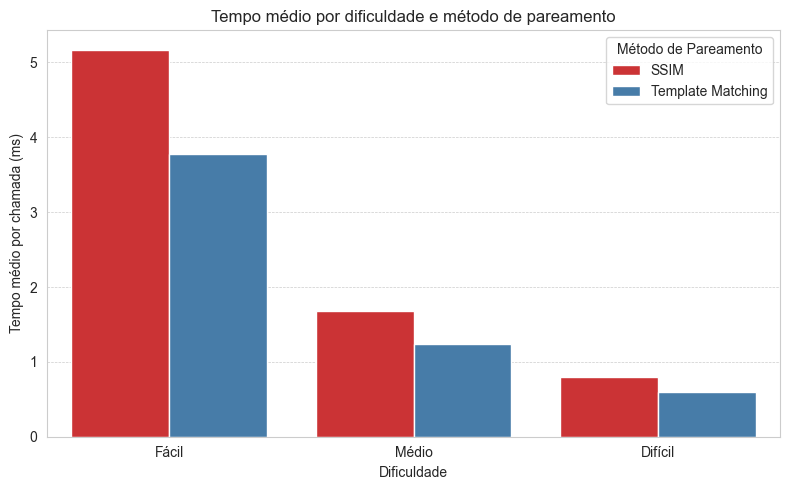

\begin{table}
\caption{Tabela de estatísticas dos tempos médios por partida (ms).}
\begin{tabular}{llrrrr}
\toprule
Método & Dificuldade & Mínimo & Máximo & Média & Desvio Padrão \\
\midrule
SSIM & Fácil & 4.599 & 7.197 & 5.189 & 0.609 \\
SSIM & Médio & 1.618 & 1.932 & 1.711 & 0.075 \\
SSIM & Difícil & 0.763 & 0.981 & 0.835 & 0.063 \\
Template Matching & Fácil & 3.622 & 4.341 & 3.782 & 0.130 \\
Template Matching & Médio & 1.210 & 1.285 & 1.245 & 0.017 \\
Template Matching & Difícil & 0.575 & 0.604 & 0.594 & 0.005 \\
\bottomrule
\end{tabular}
\end{table}



,Método,Dificuldade,Mínimo,Máximo,Média,Desvio Padrão
0,SSIM,Fácil,4.599,7.197,5.189,0.609
1,SSIM,Médio,1.618,1.932,1.711,0.075
2,SSIM,Difícil,0.763,0.981,0.835,0.063
3,Template Matching,Fácil,3.622,4.341,3.782,0.130
4,Template Matching,Médio,1.210,1.285,1.245,0.017
5,Template Matching,Difícil,0.575,0.604,0.594,0.005


In [32]:
# Carrega os resultados
df = pd.read_parquet(RESULTS_DIR / "resultados_think_distrocards_all.parquet")

# Aplica nomes legíveis
df["dificuldade_legivel"] = df["dificuldade"].map(NOMES_DIFICULDADE)
df["metodo_legivel"] = df["metodo"].map(NOMES_PARES)

# Calcula tempo total
df["tempo_total_ns"] = df["tempo_medio_chamada"] * df["chamadas"]

# Cálculo da média ponderada por grupo
df_agg = (
    df.groupby(["dificuldade_legivel", "metodo_legivel"], observed=False)
    .agg(tempo_total_ns=("tempo_total_ns", "sum"), total_chamadas=("chamadas", "sum"))
    .reset_index()
)

df_agg["tempo_medio_ponderado"], unidade = ajustar_unidade_tempo(
    df_agg["tempo_total_ns"] / df_agg["total_chamadas"]
)

# Ordena categorias para o eixo X

df_agg["dificuldade_legivel"] = pd.Categorical(
    df_agg["dificuldade_legivel"], categories=ORDEM_DIFICULDADE, ordered=True
)

# Cria o gráfico
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")

ax = sns.barplot(
    data=df_agg,
    x="dificuldade_legivel",
    y="tempo_medio_ponderado",
    hue="metodo_legivel",
    palette="Set1",
)

plt.title("Tempo médio por dificuldade e método de pareamento")
plt.xlabel("Dificuldade")
plt.ylabel(f"Tempo médio por chamada ({unidade})")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.legend(title="Método de Pareamento")
plt.tight_layout()
plt.show()

# Cria a Tabela
df["dificuldade_legivel"] = pd.Categorical(df["dificuldade_legivel"], categories=ORDEM_DIFICULDADE, ordered=True)
df["tempo_medio_ajustado"], unidade = ajustar_unidade_tempo(df["tempo_medio_chamada"])
tabela_stats = (
    df
    .groupby(["metodo_legivel", "dificuldade_legivel"], observed=False)["tempo_medio_ajustado"]
    .agg(["min", "max", "mean", "std"])
    .reset_index()
    .rename(columns={
        "metodo_legivel": "Método",
        "dificuldade_legivel": "Dificuldade",
        "min": "Mínimo",
        "max": "Máximo",
        "mean": "Média",
        "std": "Desvio Padrão"
    })
    .sort_values(by=["Método", "Dificuldade"])
)

# Para colar no LaTeX
print(tabela_stats.to_latex(
    index=False,
    float_format="%.3f",
    caption=f"Tabela de estatísticas dos tempos médios por partida ({unidade})."
))

# Exibição estilizada no notebook
tabela_stats.style.format({
    "Mínimo": "{:.3f}",
    "Máximo": "{:.3f}",
    "Média": "{:.3f}",
    "Desvio Padrão": "{:.3f}"
})

Métrica 3: Desempenho qualitativo do Think

3 Gráficos um para cada threshold, dividido em método e dificuldade, medindo as métricas precisão e recall

Precisão	“Quando ele diz que é par, quantas vezes está certo?”

Cobertura (Recall)	“De todos os pares que havia, quantos ele realmente formou?”

Na escrita explicar utilizando um itemize o que seria nesse contexto um True Positive, False Positive, ... etc. 

 Sigla | Nome                | No contexto do jogo da memória                          |
| ----- | ------------------- | ------------------------------------------------------- |
| TP    | Verdadeiro Positivo | O bot disse que **era um par** e realmente **era**      |
| FP    | Falso Positivo      | O bot disse que **era um par**, mas **não era**         |
| FN    | Falso Negativo      | O bot **não fez o par**, mas **as cartas eram iguais**  |
| TN    | Verdadeiro Negativo | O bot disse que **não era par** e realmente **não era** |


Colocar a fórmula do Recall, e Precisão.

| Métrica      | Fórmula matemática                                                                                              |
| ------------ | --------------------------------------------------------------------------------------------------------------- |
| **Precisão** | $\displaystyle \text{Precisão} = \frac{TP}{TP + FP}$                                                            |
| **Recall**   | $\displaystyle \text{Recall} = \frac{TP}{TP + FN}$                                                              |
| **F1-score** | $\displaystyle \text{F1} = 2 \cdot \frac{\text{Precisão} \cdot \text{Recall}}{\text{Precisão} + \text{Recall}}$ |
| **Acurácia** | $\displaystyle \text{Acurácia} = \frac{TP + TN}{TP + FP + FN + TN}$                                             |


Colocar o F1-Score também

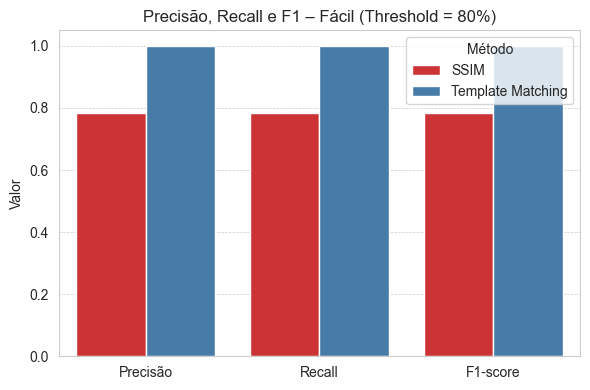

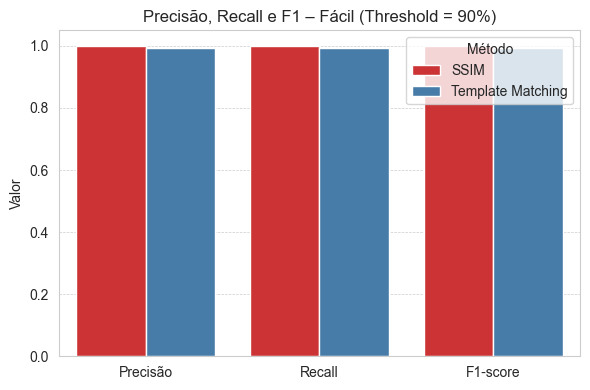

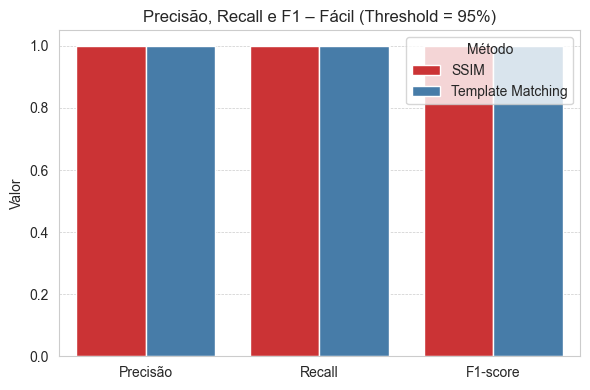

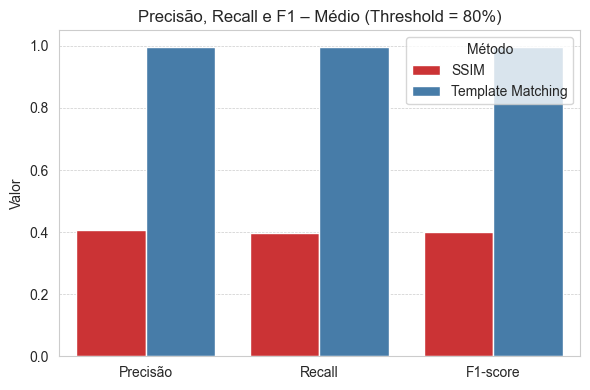

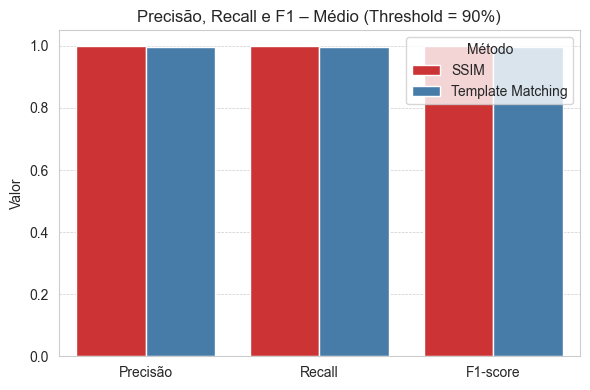

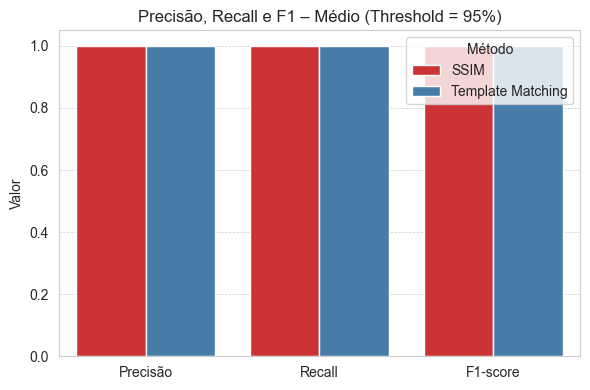

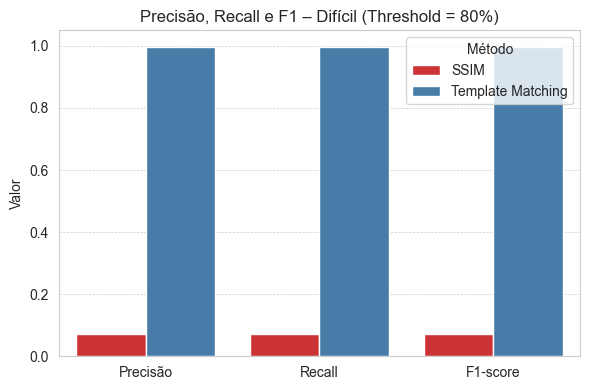

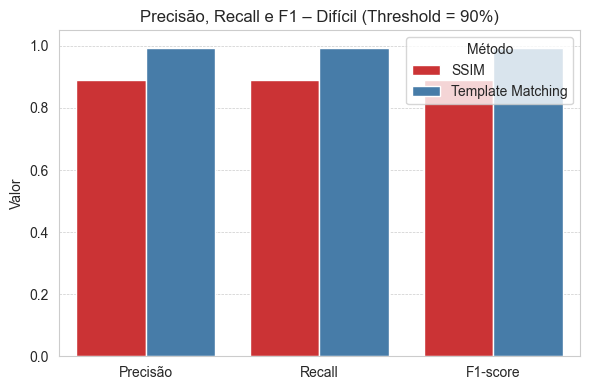

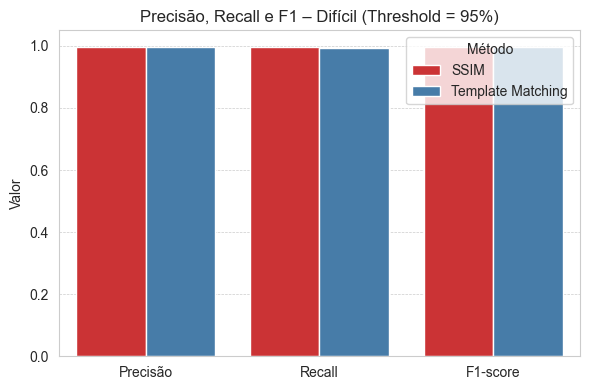

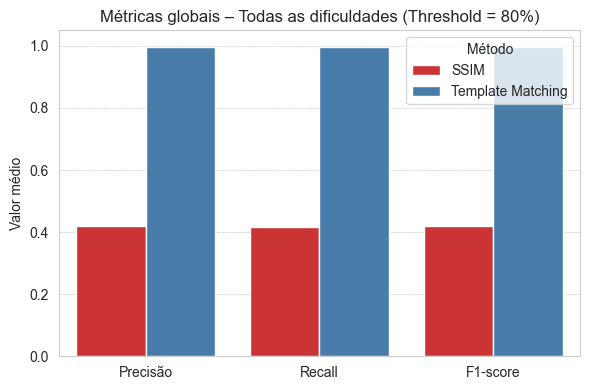

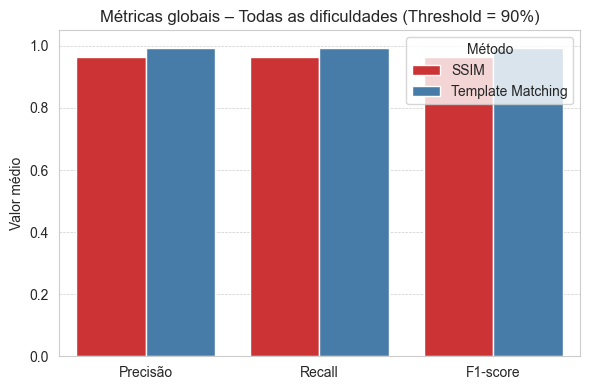

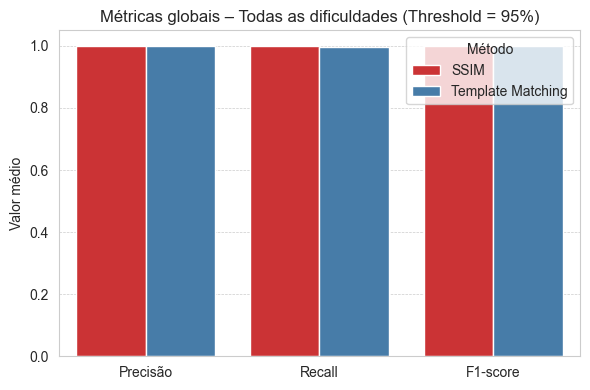

,Método,Dificuldade,Métrica,Threshold (%),Mínimo,Máximo,Média,Desvio Padrão
0,SSIM,Fácil,F1-score,80,0.667,1.000,0.783,0.163
3,SSIM,Fácil,Precisão,80,0.667,1.000,0.783,0.163
6,SSIM,Fácil,Recall,80,0.667,1.000,0.783,0.163
1,SSIM,Fácil,F1-score,90,1.000,1.000,1.000,0.000
4,SSIM,Fácil,Precisão,90,1.000,1.000,1.000,0.000
7,SSIM,Fácil,Recall,90,1.000,1.000,1.000,0.000
2,SSIM,Fácil,F1-score,95,1.000,1.000,1.000,0.000
5,SSIM,Fácil,Precisão,95,1.000,1.000,1.000,0.000
8,SSIM,Fácil,Recall,95,1.000,1.000,1.000,0.000
27,Template Matching,Fácil,F1-score,80,1.000,1.000,1.000,0.000


\begin{tabular}{lllrrrrr}
\toprule
Método & Dificuldade & Métrica & Threshold (%) & Mínimo & Máximo & Média & Desvio Padrão \\
\midrule
SSIM & Fácil & F1-score & 80 & 0.667 & 1.000 & 0.783 & 0.163 \\
SSIM & Fácil & Precisão & 80 & 0.667 & 1.000 & 0.783 & 0.163 \\
SSIM & Fácil & Recall & 80 & 0.667 & 1.000 & 0.783 & 0.163 \\
SSIM & Fácil & F1-score & 90 & 1.000 & 1.000 & 1.000 & 0.000 \\
SSIM & Fácil & Precisão & 90 & 1.000 & 1.000 & 1.000 & 0.000 \\
SSIM & Fácil & Recall & 90 & 1.000 & 1.000 & 1.000 & 0.000 \\
SSIM & Fácil & F1-score & 95 & 1.000 & 1.000 & 1.000 & 0.000 \\
SSIM & Fácil & Precisão & 95 & 1.000 & 1.000 & 1.000 & 0.000 \\
SSIM & Fácil & Recall & 95 & 1.000 & 1.000 & 1.000 & 0.000 \\
Template Matching & Fácil & F1-score & 80 & 1.000 & 1.000 & 1.000 & 0.000 \\
Template Matching & Fácil & Precisão & 80 & 1.000 & 1.000 & 1.000 & 0.000 \\
Template Matching & Fácil & Recall & 80 & 1.000 & 1.000 & 1.000 & 0.000 \\
Template Matching & Fácil & F1-score & 90 & 0.833 & 1.000 & 0.992

In [36]:
# Carrega os resultados
df = pd.read_parquet(RESULTS_DIR / "resultados_think_distrocards_all.parquet")

# Calcula métricas para todas as dificuldades
df["precisao"] = df["acertos"] / (df["acertos"] + df["erros"])
df["recall"] = df.apply(lambda row: row["acertos"] / TOTAL_PARES[row["dificuldade"]], axis=1)
df["f1"] = np.where(
    (df["precisao"] + df["recall"]) == 0,
    0,
    2 * (df["precisao"] * df["recall"]) / (df["precisao"] + df["recall"])
)

# Reorganiza o dataframe para formato long
df_long = df.melt(
    id_vars=["threshold", "metodo", "dificuldade"],
    value_vars=["precisao", "recall", "f1"],
    var_name="métrica", value_name="valor"
)

# Nomes legíveis
df_long["metodo_legivel"] = df_long["metodo"].map(NOMES_PARES)
df_long["métrica"] = df_long["métrica"].map(NOME_METRICA)
df_long["threshold_%"] = df_long["threshold"].astype(int)
df_long["dificuldade_legivel"] = df_long["dificuldade"].map(NOMES_DIFICULDADE)

# Gera 9 plots separados (3 dificuldades × 3 thresholds)
sns.set_style("whitegrid")
for dificuldade in ["Fácil", "Médio", "Difícil"]:
    for thr in [80, 90, 95]:
        plt.figure(figsize=(6, 4))
        df_plot = df_long[
            (df_long["threshold_%"] == thr) &
            (df_long["dificuldade_legivel"] == dificuldade)
        ]
        sns.barplot(
            data=df_plot,
            x="métrica", y="valor",
            hue="metodo_legivel", palette="Set1", errorbar=None
        )
        plt.title(f"Precisão, Recall e F1 – {dificuldade} (Threshold = {thr}%)")
        plt.xlabel("")
        plt.ylabel("Valor")
        plt.ylim(0, 1.05)
        plt.legend(title="Método")
        plt.grid(axis="y", linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

# Gera 3 plots (3 thresholds) 
for thr in [80, 90, 95]:
    plt.figure(figsize=(6, 4))
    df_plot = df_long[df_long["threshold_%"] == thr]
    
    sns.barplot(
        data=df_plot,
        x="métrica", y="valor",
        hue="metodo_legivel", palette="Set1",
        errorbar=None  # sem barras de erro
    )

    plt.title(f"Métricas globais – Todas as dificuldades (Threshold = {thr}%)")
    plt.xlabel("")
    plt.ylabel("Valor médio")
    plt.ylim(0, 1.05)
    plt.legend(title="Método")
    plt.grid(axis="y", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    
df_long["dificuldade_legivel"] = pd.Categorical(
    df_long["dificuldade_legivel"],
    categories=ORDEM_DIFICULDADE,
    ordered=True
)

# Agrupa por método, métrica, threshold e dificuldade
tabela_stats = (
    df_long
    .groupby(
        ["metodo_legivel", "dificuldade_legivel", "métrica", "threshold_%"],
        observed=False
    )["valor"]
    .agg(["min", "max", "mean", "std"])
    .reset_index()
    .rename(columns={
        "metodo_legivel":      "Método",
        "dificuldade_legivel": "Dificuldade",
        "métrica":             "Métrica",
        "threshold_%":         "Threshold (%)",
        "min":                 "Mínimo",
        "max":                 "Máximo",
        "mean":                "Média",
        "std":                 "Desvio Padrão",
    })
    .sort_values(by=["Dificuldade", "Método", "Threshold (%)", "Métrica"])
)

# Exibe no notebook (3 casas decimais)
display(
    tabela_stats.style.format({
        "Mínimo": "{:.3f}",
        "Máximo": "{:.3f}",
        "Média":  "{:.3f}",
        "Desvio Padrão": "{:.3f}",
        "Threshold (%)": "{}",
    })
)

# Exporta para LaTeX, se quiser
print(tabela_stats.to_latex(index=False, float_format="%.3f"))

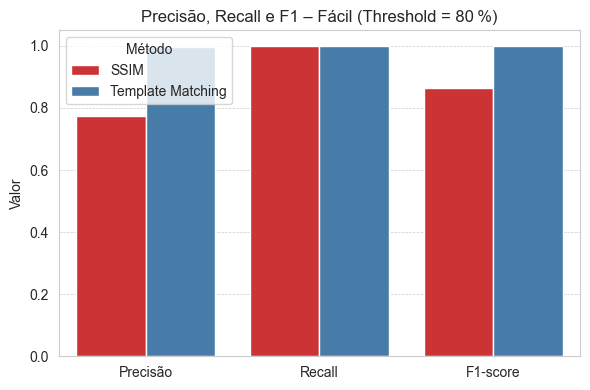

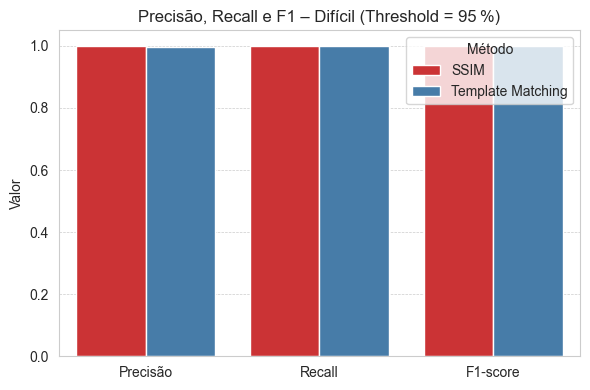

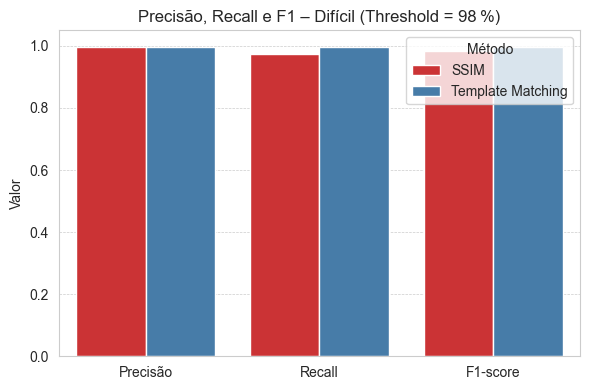

métrica,Método,Dificuldade,Threshold (%),Precisão,Recall,F1-score
0,SSIM,Fácil,80,0.773,1.000,0.864
3,Template Matching,Fácil,80,0.997,1.000,0.998
1,SSIM,Difícil,95,1.000,1.000,1.000
4,Template Matching,Difícil,95,0.998,1.000,0.999
2,SSIM,Difícil,98,0.995,0.974,0.984
5,Template Matching,Difícil,98,0.998,0.997,0.997


\begin{tabular}{llrrrr}
\toprule
Método & Dificuldade & Threshold (%) & Precisão & Recall & F1-score \\
\midrule
SSIM & Fácil & 80 & 0.773 & 1.000 & 0.864 \\
Template Matching & Fácil & 80 & 0.997 & 1.000 & 0.998 \\
SSIM & Difícil & 95 & 1.000 & 1.000 & 1.000 \\
Template Matching & Difícil & 95 & 0.998 & 1.000 & 0.999 \\
SSIM & Difícil & 98 & 0.995 & 0.974 & 0.984 \\
Template Matching & Difícil & 98 & 0.998 & 0.997 & 0.997 \\
\bottomrule
\end{tabular}



In [9]:
# Carrega os dados
df = pd.read_parquet(RESULTS_DIR /"resultados_think_distrocards_quality.parquet")

# Cria um DataFrame temporário só com as colunas essenciais
df_temp = pd.DataFrame({
    "TP": df["acertos"],
    "FP": df["erros"],
    "total_pares": df["dificuldade"].map(TOTAL_PARES)
})
df_temp["FN"] = df_temp["total_pares"] - (df_temp["TP"] + df_temp["FP"])

# Calcula as métricas
df_temp["precisao"] = df_temp["TP"] / (df_temp["TP"] + df_temp["FP"])
df_temp["recall"] = df_temp["TP"] / (df_temp["TP"] + df_temp["FN"])
df_temp["f1"] = np.where(
    (df_temp["precisao"] + df_temp["recall"]) == 0,
    0,
    2 * (df_temp["precisao"] * df_temp["recall"]) / (df_temp["precisao"] + df_temp["recall"])
)


# Junta as métricas calculadas de volta no DataFrame principal
df[["precisao", "recall", "f1"]] = df_temp[["precisao", "recall", "f1"]]

# Reorganiza o dataframe para formato long
df_long = df.melt(
    id_vars=["threshold", "metodo", "dificuldade"],
    value_vars=["precisao", "recall", "f1"],
    var_name="métrica", value_name="valor"
)

# Nomes legíveis
df_long["metodo_legivel"] = df_long["metodo"].map(NOMES_PARES)
df_long["métrica"] = df_long["métrica"].map(NOME_METRICA)
df_long["threshold_%"] = (df_long["threshold"] * 100).astype(int)
df_long["dificuldade_legivel"] = df_long["dificuldade"].map(NOMES_DIFICULDADE)

# Plota os 3 gráficos
sns.set_style("whitegrid")
thresholds = sorted(df_long["threshold_%"].unique())
for thr in thresholds:
    diffs = df_long.loc[df_long["threshold_%"] == thr, "dificuldade_legivel"].unique()
    for dificuldade in diffs:
        plt.figure(figsize=(6, 4))

        df_plot = df_long[
            (df_long["threshold_%"] == thr) &
            (df_long["dificuldade_legivel"] == dificuldade)
        ]

        sns.barplot(
            data=df_plot,
            x="métrica", y="valor",
            hue="metodo_legivel",
            palette="Set1",
            errorbar=None
        )
        plt.title(f"Precisão, Recall e F1 – {dificuldade} (Threshold = {thr} %)")
        plt.xlabel("")
        plt.ylabel("Valor")
        plt.ylim(0, 1.05)
        plt.legend(title="Método")
        plt.grid(axis="y", linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()


df_long["dificuldade_legivel"] = pd.Categorical(
    df_long["dificuldade_legivel"],
    categories=ORDEM_DIFICULDADE,
    ordered=True
)

# Agrupa por método, métrica, threshold e dificuldade
tabela_stats = (
    df_long
    .groupby(
        ["metodo_legivel", "dificuldade_legivel", "threshold_%", "métrica"],
        observed=True
    )["valor"]
    .mean()
    .reset_index()
    .pivot(
        index=["metodo_legivel", "dificuldade_legivel", "threshold_%"],
        columns="métrica",
        values="valor"
    )
    .reset_index()
    .rename(columns={
        "metodo_legivel":      "Método",
        "dificuldade_legivel": "Dificuldade",
        "threshold_%":         "Threshold (%)",
    })
    .sort_values(by=["Dificuldade", "Threshold (%)", "Método", ])
)

if "F1-score" in tabela_stats.columns:
    col_f1 = tabela_stats.pop("F1-score")
    tabela_stats["F1-score"] = col_f1  

# Exibe no notebook (3 casas decimais)
display(
    tabela_stats.style.format({
        "Threshold (%)": "{}",
        "Precisão": "{:.3f}",
        "Recall": "{:.3f}",
        "F1-score":  "{:.3f}",
    })
)

# Exporta para LaTeX, se quiser
print(tabela_stats.to_latex(index=False, float_format="%.3f"))

In [ ]:
# Define TP, FP e FN corretamente
TP = df["acertos"]
FP = df["erros"]
total_pares = df["dificuldade"].map(TOTAL_PARES)
FN = total_pares - (TP + FP)

# Calcula métricas com base na nova lógica
precisao = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = np.where(
    (precisao + recall) == 0,
    0,
    2 * (precisao * recall) / (precisao + recall)
)

# Novo DataFrame com as métricas
df_metrics = pd.DataFrame({
    "metodo": df["metodo"],
    "dificuldade": df["dificuldade"],
    "threshold": df["threshold"],
    "TP": TP,
    "FP": FP,
    "FN": FN,
    "soma_TP_FP_FN": TP + FP + FN,
    "total_pares": total_pares,
    "precisao": precisao,
    "recall": recall,
    "f1": f1
})

# Verificação: soma deve bater com total_pares
df_metrics["verificacao"] = df_metrics["soma_TP_FP_FN"] == df_metrics["total_pares"]

# Exibe para revisão
display(df_metrics.round(3))


,metodo,dificuldade,threshold,TP,FP,FN,soma_TP_FP_FN,total_pares,precisao,recall,f1,verificacao
0,SSIM,EASY,0.80,4,2,0,6,6,0.667,1.0,0.800,True
1,SSIM,EASY,0.80,4,2,0,6,6,0.667,1.0,0.800,True
2,SSIM,EASY,0.80,6,0,0,6,6,1.000,1.0,1.000,True
3,SSIM,EASY,0.80,4,2,0,6,6,0.667,1.0,0.800,True
4,SSIM,EASY,0.80,6,0,0,6,6,1.000,1.0,1.000,True
...,...,...,...,...,...,...,...,...,...,...,...,...
295,TEMPLATE_MATCHING,HARD,0.95,24,0,0,24,24,1.000,1.0,1.000,True
296,TEMPLATE_MATCHING,HARD,0.95,23,1,0,24,24,0.958,1.0,0.979,True
297,TEMPLATE_MATCHING,HARD,0.95,24,0,0,24,24,1.000,1.0,1.000,True
298,TEMPLATE_MATCHING,HARD,0.95,24,0,0,24,24,1.000,1.0,1.000,True


## Taisei Project

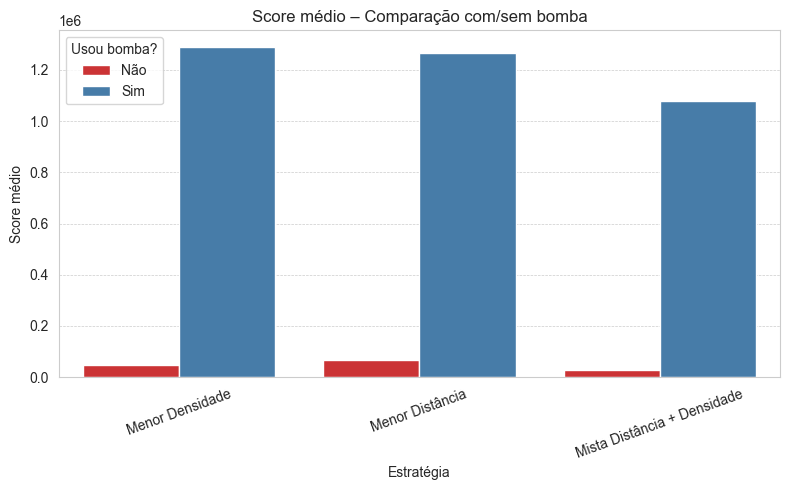

,Estratégia,Mínimo (Não),Mínimo (Sim),Máximo (Não),Máximo (Sim),Média (Não),Média (Sim),Desvio Padrão (Não),Desvio Padrão (Sim)
0,Menor Densidade,6066.00,590266.00,100867.00,2155691.00,46021.84,1290250.16,23214.23,336039.21
1,Menor Distância,10105.00,232908.00,152954.00,2105524.00,66591.08,1264303.74,29082.68,394333.37
2,Mista Distância + Densidade,5617.00,291295.00,66322.00,1881725.00,28077.86,1079829.34,19123.38,342216.55



LaTeX (comparação bomba vs sem bomba, pivotada):
\begin{tabular}{lrrrrrrrr}
\toprule
Estratégia & Mínimo (Não) & Mínimo (Sim) & Máximo (Não) & Máximo (Sim) & Média (Não) & Média (Sim) & Desvio Padrão (Não) & Desvio Padrão (Sim) \\
\midrule
Menor Densidade & 6066.00 & 590266.00 & 100867.00 & 2155691.00 & 46021.84 & 1290250.16 & 23214.23 & 336039.21 \\
Menor Distância & 10105.00 & 232908.00 & 152954.00 & 2105524.00 & 66591.08 & 1264303.74 & 29082.68 & 394333.37 \\
Mista Distância + Densidade & 5617.00 & 291295.00 & 66322.00 & 1881725.00 & 28077.86 & 1079829.34 & 19123.38 & 342216.55 \\
\bottomrule
\end{tabular}



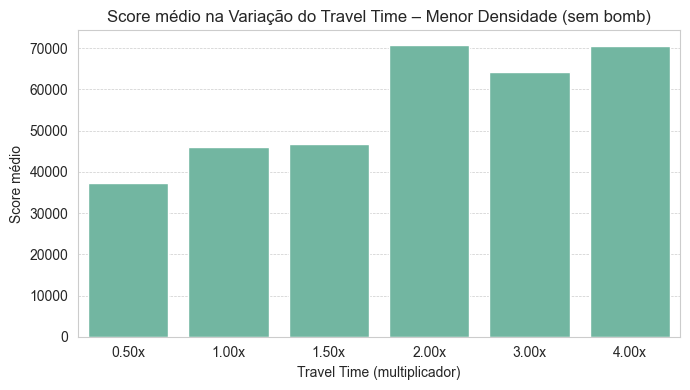

,Travel Time (multiplicador),Mínimo,Máximo,Média,Desvio Padrão
0,0.50x,4048.00,115762.00,37268.56,21554.58
1,1.00x,6066.00,100867.00,46021.84,23214.23
2,1.50x,6622.00,102351.00,46826.22,24681.27
3,2.00x,9033.00,141846.00,70803.02,32355.27
4,3.00x,23498.00,142006.00,64272.14,34331.62
5,4.00x,18080.00,145310.00,70625.36,30167.20



LaTeX (Menor Densidade, variação Travel Time):
\begin{tabular}{lrrrr}
\toprule
Travel Time (multiplicador) & Mínimo & Máximo & Média & Desvio Padrão \\
\midrule
0.50x & 4048 & 115762 & 37268.56 & 21554.58 \\
1.00x & 6066 & 100867 & 46021.84 & 23214.23 \\
1.50x & 6622 & 102351 & 46826.22 & 24681.27 \\
2.00x & 9033 & 141846 & 70803.02 & 32355.27 \\
3.00x & 23498 & 142006 & 64272.14 & 34331.62 \\
4.00x & 18080 & 145310 & 70625.36 & 30167.20 \\
\bottomrule
\end{tabular}



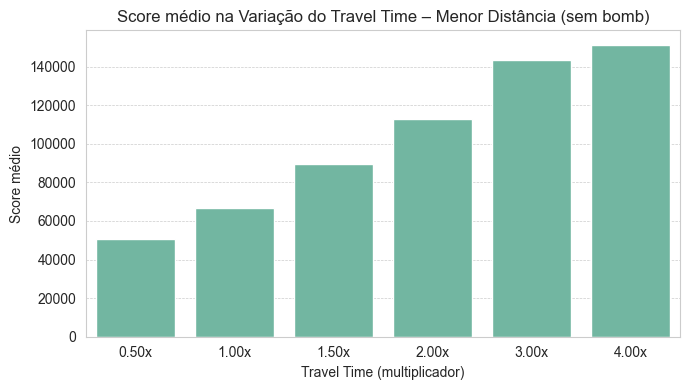

,Travel Time (multiplicador),Mínimo,Máximo,Média,Desvio Padrão
0,0.50x,13305.00,108424.00,50405.36,19186.18
1,1.00x,10105.00,152954.00,66591.08,29082.68
2,1.50x,12985.00,642659.00,89520.18,86230.55
3,2.00x,10151.00,467128.00,112848.04,106502.85
4,3.00x,6842.00,585587.00,143466.64,131982.15
5,4.00x,12434.00,561921.00,151187.94,121178.64



LaTeX (Menor Distância, variação Travel Time):
\begin{tabular}{lrrrr}
\toprule
Travel Time (multiplicador) & Mínimo & Máximo & Média & Desvio Padrão \\
\midrule
0.50x & 13305 & 108424 & 50405.36 & 19186.18 \\
1.00x & 10105 & 152954 & 66591.08 & 29082.68 \\
1.50x & 12985 & 642659 & 89520.18 & 86230.55 \\
2.00x & 10151 & 467128 & 112848.04 & 106502.85 \\
3.00x & 6842 & 585587 & 143466.64 & 131982.15 \\
4.00x & 12434 & 561921 & 151187.94 & 121178.64 \\
\bottomrule
\end{tabular}



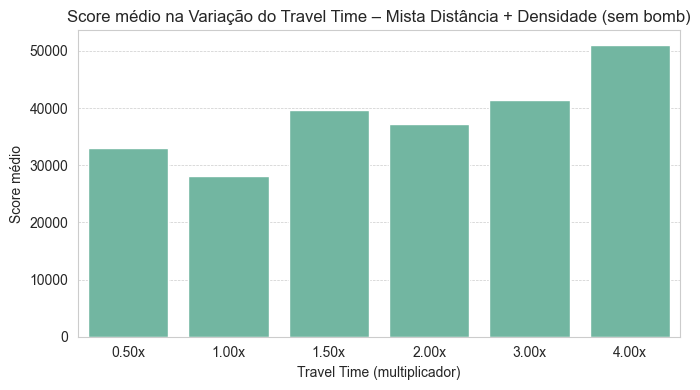

,Travel Time (multiplicador),Mínimo,Máximo,Média,Desvio Padrão
0,0.50x,5259.00,78856.00,33106.84,18989.47
1,1.00x,5617.00,66322.00,28077.86,19123.38
2,1.50x,5301.00,130088.00,39662.36,24944.11
3,2.00x,6440.00,77727.00,37191.76,19871.29
4,3.00x,6467.00,79379.00,41372.80,21802.53
5,4.00x,10445.00,132648.00,51047.98,26712.16



LaTeX (Mista Distância + Densidade, variação Travel Time):
\begin{tabular}{lrrrr}
\toprule
Travel Time (multiplicador) & Mínimo & Máximo & Média & Desvio Padrão \\
\midrule
0.50x & 5259 & 78856 & 33106.84 & 18989.47 \\
1.00x & 5617 & 66322 & 28077.86 & 19123.38 \\
1.50x & 5301 & 130088 & 39662.36 & 24944.11 \\
2.00x & 6440 & 77727 & 37191.76 & 19871.29 \\
3.00x & 6467 & 79379 & 41372.80 & 21802.53 \\
4.00x & 10445 & 132648 & 51047.98 & 26712.16 \\
\bottomrule
\end{tabular}



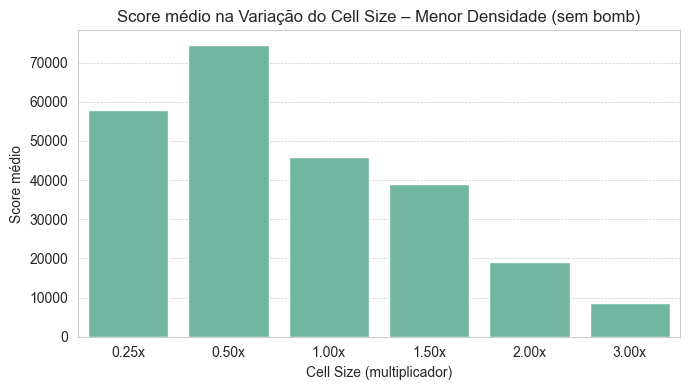

,Cell Size (multiplicador),Mínimo,Máximo,Média,Desvio Padrão
0,0.25x,5617.00,134908.00,57789.40,25399.58
1,0.50x,20085.00,152569.00,74522.00,31277.90
2,1.00x,6066.00,100867.00,46021.84,23214.23
3,1.50x,7104.00,117248.00,38876.98,21862.47
4,2.00x,4546.00,71232.00,19022.96,16766.66
5,3.00x,4945.00,41697.00,8534.18,6537.93



LaTeX (Menor Densidade, variação Cell Size):
\begin{tabular}{lrrrr}
\toprule
Cell Size (multiplicador) & Mínimo & Máximo & Média & Desvio Padrão \\
\midrule
0.25x & 5617 & 134908 & 57789.40 & 25399.58 \\
0.50x & 20085 & 152569 & 74522.00 & 31277.90 \\
1.00x & 6066 & 100867 & 46021.84 & 23214.23 \\
1.50x & 7104 & 117248 & 38876.98 & 21862.47 \\
2.00x & 4546 & 71232 & 19022.96 & 16766.66 \\
3.00x & 4945 & 41697 & 8534.18 & 6537.93 \\
\bottomrule
\end{tabular}



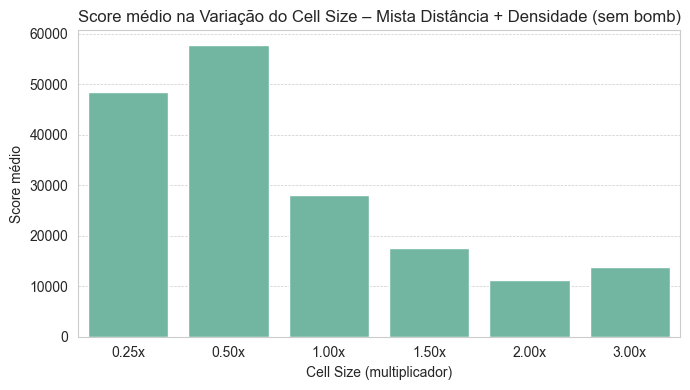

,Cell Size (multiplicador),Mínimo,Máximo,Média,Desvio Padrão
0,0.25x,7666.00,100395.00,48447.80,19567.46
1,0.50x,23864.00,122969.00,57761.84,19580.24
2,1.00x,5617.00,66322.00,28077.86,19123.38
3,1.50x,3924.00,51600.00,17514.38,11557.22
4,2.00x,5006.00,43805.00,11176.92,8194.15
5,3.00x,3991.00,46435.00,13884.68,9389.72



LaTeX (Mista Distância + Densidade, variação Cell Size):
\begin{tabular}{lrrrr}
\toprule
Cell Size (multiplicador) & Mínimo & Máximo & Média & Desvio Padrão \\
\midrule
0.25x & 7666 & 100395 & 48447.80 & 19567.46 \\
0.50x & 23864 & 122969 & 57761.84 & 19580.24 \\
1.00x & 5617 & 66322 & 28077.86 & 19123.38 \\
1.50x & 3924 & 51600 & 17514.38 & 11557.22 \\
2.00x & 5006 & 43805 & 11176.92 & 8194.15 \\
3.00x & 3991 & 46435 & 13884.68 & 9389.72 \\
\bottomrule
\end{tabular}



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===================================
# Pré-processamento global
# ===================================
def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aplica transformações iniciais para deixar o dataframe pronto:
    - Nomes legíveis para estratégias e bomba
    - Criação de colunas formatadas para travel_time e cell_size
    """
    df_copy = df.copy()

    NOMES_STRATEGY = {
        "MIX_DISTANCIA_DENSIDADE": "Mista Distância + Densidade",
        "MENOR_DISTANCIA": "Menor Distância",
        "MENOR_DENSIDADE": "Menor Densidade",
    }
    df_copy["strategy_legivel"] = df_copy["strategy"].map(NOMES_STRATEGY).fillna(df_copy["strategy"])
    df_copy["bomb_legivel"] = df_copy["bomb"].map({True: "Sim", False: "Não"})
    df_copy["travel_time_rel"] = df_copy["travel_time"].apply(lambda x: f"{x:.2f}x")
    df_copy["cell_size_rel"] = df_copy["cell_size"].apply(lambda x: f"{x:.2f}x")

    return df_copy


# ===================================
# Função auxiliar para agregar métricas
# ===================================
def agrega_metricas(df: pd.DataFrame, group_cols: list[str]) -> pd.DataFrame:
    """
    Recebe um dataframe e retorna outro com métricas agregadas
    (mínimo, máximo, média, desvio padrão) agrupado por group_cols.
    """
    df_agg = (
        df.groupby(group_cols, observed=False)["score"]
        .agg(["min", "max", "mean", "std"])
        .reset_index()
        .rename(columns={
            "min": "Mínimo",
            "max": "Máximo",
            "mean": "Média",
            "std": "Desvio Padrão"
        })
    )
    return df_agg


# ===================================
# Gráfico 1: Comparação com/sem bomba
# ===================================
def get_df_bomb(df: pd.DataFrame) -> pd.DataFrame:
    return df[(df["cell_size"] == 1.0) & (df["travel_time"] == 1.0)].copy()


# ===================================
# Gráficos 2–4: Travel Time por estratégia
# ===================================
def get_df_travel_time(df: pd.DataFrame, strategy: str) -> pd.DataFrame:
    df_strat = df[
        (df["strategy_legivel"] == strategy)
        & (df["bomb"] == False)
        & (df["cell_size"] == 1.0)
    ].copy()

    if df_strat["travel_time"].nunique() <= 1:
        return pd.DataFrame()

    # Ordenar eixo
    df_strat["x_val"] = df_strat["travel_time_rel"].str.replace("x", "").astype(float)
    df_strat = df_strat.sort_values("x_val")
    df_strat["travel_time_rel"] = pd.Categorical(
        df_strat["travel_time_rel"],
        categories=df_strat["travel_time_rel"].unique(),
        ordered=True
    )
    return df_strat


# ===================================
# Gráficos 5–6: Cell Size por estratégia de densidade
# ===================================
def get_df_cell_size(df: pd.DataFrame, strategy: str) -> pd.DataFrame:
    df_strat = df[
        (df["strategy_legivel"] == strategy)
        & (df["bomb"] == False)
        & (df["travel_time"] == 1.0)
    ].copy()

    if df_strat["cell_size"].nunique() <= 1:
        return pd.DataFrame()

    # Ordenar eixo
    df_strat["x_val"] = df_strat["cell_size_rel"].str.replace("x", "").astype(float)
    df_strat = df_strat.sort_values("x_val")
    df_strat["cell_size_rel"] = pd.Categorical(
        df_strat["cell_size_rel"],
        categories=df_strat["cell_size_rel"].unique(),
        ordered=True
    )
    return df_strat

# ===================================
# MAIN SCRIPT
# ===================================
# Carrega os dados
df_raw = pd.read_parquet(RESULTS_DIR / "resultados_dodge_final.parquet")
df = preprocess_dataframe(df_raw)


# -------------------------------
# Gráfico 1: Comparação Bomba x Sem Bomba (default)
# -------------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

df_plot = get_df_bomb(df)

sns.barplot(
    data=df_plot,
    x="strategy_legivel",
    y="score",
    hue="bomb_legivel",
    palette="Set1",
    errorbar=None
)

plt.title("Score médio – Comparação com/sem bomba")
plt.xlabel("Estratégia")
plt.ylabel("Score médio")
plt.xticks(rotation=20)
plt.legend(title="Usou bomba?")
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# -------------------------------
# Tabela pivotada do Gráfico 1
# -------------------------------
tabela_bomba_pivot = (
    df_plot.groupby(["strategy_legivel", "bomb_legivel"], observed=False)["score"]
    .agg(["min", "max", "mean", "std"])
    .rename(columns={
        "min": "Mínimo", "max": "Máximo", "mean": "Média", "std": "Desvio Padrão"
    })
    .reset_index()
    .pivot_table(
        index="strategy_legivel", 
        columns="bomb_legivel", 
        values=["Mínimo", "Máximo", "Média", "Desvio Padrão"]
    )
)
tabela_bomba_pivot.columns = [f"{col[0]} ({col[1]})" for col in tabela_bomba_pivot.columns]
tabela_bomba_pivot = tabela_bomba_pivot.reset_index().rename(columns={"strategy_legivel": "Estratégia"})
ordem_metricas = ["Mínimo", "Máximo", "Média", "Desvio Padrão"]
ordem_bomb = ["Não", "Sim"]
colunas_ordenadas = ["Estratégia"] + [f"{m} ({b})" for m in ordem_metricas for b in ordem_bomb]
tabela_bomba_pivot = tabela_bomba_pivot[colunas_ordenadas]

display(
    tabela_bomba_pivot.style.format("{:.2f}", subset=tabela_bomba_pivot.select_dtypes("number").columns)
)
print("\nLaTeX (comparação bomba vs sem bomba, pivotada):")
print(tabela_bomba_pivot.to_latex(index=False, float_format="%.2f"))

# -------------------------------
# Gráficos 2–4: Travel Time por estratégia
# -------------------------------
for strat in df["strategy_legivel"].unique():
    df_strat = get_df_travel_time(df, strat)
    if df_strat.empty:
        continue

    plt.figure(figsize=(7, 4))
    sns.barplot(
        data=df_strat,
        x="travel_time_rel",
        y="score",
        hue="strategy_legivel",
        palette="Set2",
        errorbar=None,
        legend=False
    )
    plt.title(f"Score médio na Variação do Travel Time – {strat} (sem bomb)")
    plt.xlabel("Travel Time (multiplicador)")
    plt.ylabel("Score médio")
    plt.grid(axis="y", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

    tabela_var = agrega_metricas(df_strat, ["travel_time_rel"])
    tabela_var = tabela_var.rename(columns={"travel_time_rel": "Travel Time (multiplicador)"})
    display(tabela_var.style.format("{:.2f}", subset=["Mínimo", "Máximo", "Média", "Desvio Padrão"]))
    print(f"\nLaTeX ({strat}, variação Travel Time):")
    print(tabela_var.to_latex(index=False, float_format="%.2f"))

# -------------------------------
# Gráficos 5–6: Cell Size por estratégias de densidade
# -------------------------------
estrategias_densidade = [s for s in df["strategy_legivel"].unique() if "Densidade" in s]
for strat in estrategias_densidade:
    df_strat = get_df_cell_size(df, strat)
    if df_strat.empty:
        continue

    plt.figure(figsize=(7, 4))
    sns.barplot(
        data=df_strat,
        x="cell_size_rel",
        y="score",
        hue="strategy_legivel",
        palette="Set2",
        errorbar=None,
        legend=False
    )
    plt.title(f"Score médio na Variação do Cell Size – {strat} (sem bomb)")
    plt.xlabel("Cell Size (multiplicador)")
    plt.ylabel("Score médio")
    plt.grid(axis="y", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

    tabela_var = agrega_metricas(df_strat, ["cell_size_rel"])
    tabela_var = tabela_var.rename(columns={"cell_size_rel": "Cell Size (multiplicador)"})
    display(tabela_var.style.format("{:.2f}", subset=["Mínimo", "Máximo", "Média", "Desvio Padrão"]))
    print(f"\nLaTeX ({strat}, variação Cell Size):")
    print(tabela_var.to_latex(index=False, float_format="%.2f"))

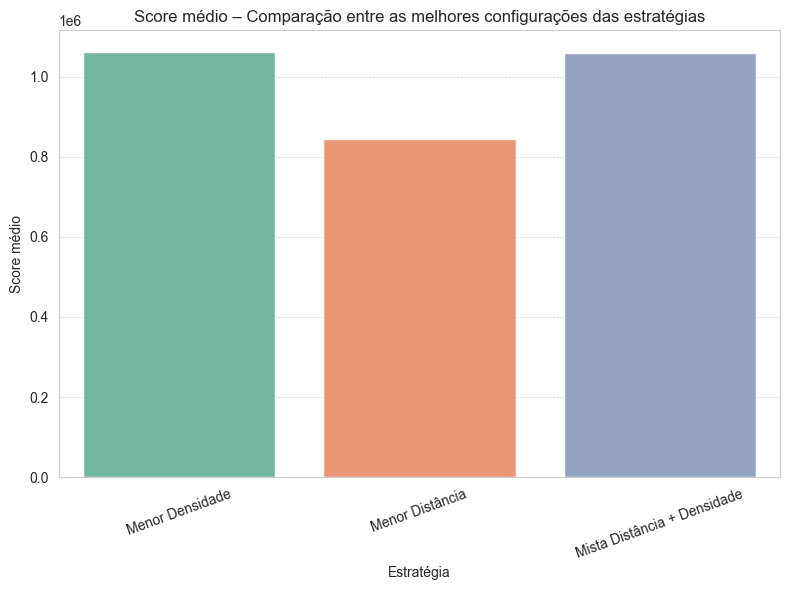

,Estratégia,Mínimo,Máximo,Média,Desvio Padrão
0,Menor Densidade,381624.00,1849185.00,1062332.94,351804.21
1,Menor Distância,24315.00,2213462.00,845250.28,434116.06
2,Mista Distância + Densidade,188739.00,2468134.00,1058417.46,354430.78



LaTeX (comparação entre estratégias):
\begin{tabular}{lrrrr}
\toprule
Estratégia & Mínimo & Máximo & Média & Desvio Padrão \\
\midrule
Menor Densidade & 381624 & 1849185 & 1062332.94 & 351804.21 \\
Menor Distância & 24315 & 2213462 & 845250.28 & 434116.06 \\
Mista Distância + Densidade & 188739 & 2468134 & 1058417.46 & 354430.78 \\
\bottomrule
\end{tabular}



In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
# -------------------------------
# Carrega o novo dataframe
# -------------------------------
RESULTS_DIR = Path("resultados")
df_raw = pd.read_parquet(RESULTS_DIR / 'resultados_dodge_best.parquet')

# Pré-processamento: nomes legíveis e multiplicadores
NOMES_STRATEGY = {
    "MIX_DISTANCIA_DENSIDADE": "Mista Distância + Densidade",
    "MENOR_DISTANCIA": "Menor Distância",
    "MENOR_DENSIDADE": "Menor Densidade",
}
df_raw["strategy_legivel"] = df_raw["strategy"].map(NOMES_STRATEGY).fillna(df_raw["strategy"])
df_raw["bomb_legivel"] = df_raw["bomb"].map({True: "Sim", False: "Não"})
df_raw["travel_time_rel"] = df_raw["travel_time"].apply(lambda x: f"{x:.2f}x")
df_raw["cell_size_rel"] = df_raw["cell_size"].apply(lambda x: f"{x:.2f}x")

# -------------------------------
# Agrupa dados (já feito no seu comentário, mas refazemos por segurança)
# -------------------------------
df_plot = df_raw.groupby(
    ["strategy_legivel", "travel_time", "bomb", "cell_size"], observed=False
).agg(
    score_min=('score', 'min'),
    score_max=('score', 'max'),
    score_mean=('score', 'mean'),
    score_std=('score', 'std')
).reset_index()

# -------------------------------
# Gráfico: Comparação das estratégias
# -------------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# Considerando score médio
sns.barplot(
    data=df_plot,
    x="strategy_legivel",
    y="score_mean",
    palette="Set2",
    hue="strategy_legivel",
    errorbar=None,
)

plt.title("Score médio – Comparação entre as melhores configurações das estratégias")
plt.xlabel("Estratégia")
plt.ylabel("Score médio")
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# -------------------------------
# Tabela de métricas agregadas
# -------------------------------
tabela_strategies = df_plot[["strategy_legivel", "score_min", "score_max", "score_mean", "score_std"]].copy()
tabela_strategies = tabela_strategies.rename(columns={
    "strategy_legivel": "Estratégia",
    "score_min": "Mínimo",
    "score_max": "Máximo",
    "score_mean": "Média",
    "score_std": "Desvio Padrão"
})

display(tabela_strategies.style.format("{:.2f}", subset=["Mínimo", "Máximo", "Média", "Desvio Padrão"]))

# -------------------------------
# Tabela LaTeX
# -------------------------------
print("\nLaTeX (comparação entre estratégias):")
print(tabela_strategies.to_latex(index=False, float_format="%.2f"))
